# Librerías

In [1]:
import math
import cmath
import scipy
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.stats import kurtosis
from apyori import apriori
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
import seaborn as sns;
sns.set_theme()
sns.set(rc={'figure.figsize':(8,6)})
from itertools import combinations
import array_to_latex as a2l
import matplotlib.colors as colors

dirfigs="figs/"
dirtabs="tablas/"
#dirfigs="/home/ogduartev/Cursos/Ciencia\ de\ datos\ energéticos/textos/agrupamientoDeConsumos/figs/"
#dirtabs="/home/ogduartev/Cursos/Ciencia\ de\ datos\ energéticos/textos/agrupamientoDeConsumos/tablas/"

# Funciones

In [2]:
def leerUN(target_url):
    df = pd.read_csv(target_url,sep='\t');
    df['FECHA']=pd.to_datetime(df['FECHA'],format='%Y/%m/%d')
    df['HORA']=pd.to_datetime(df['HORA'],format='%H:%M:%S')
    hora=[''] * df["HORA"].size
    for ind in df.index:
        x=df["HORA"][ind]
        hora[ind]=x.strftime("%H")
    df["HORA"]=hora
    return df;

def fasores(Ia,Ib,Ic,giro):
    # obtención de los ángulos de un triángulo a partir de sus lados
    mm=(Ib*Ib + Ic*Ic - Ia*Ia)/(2*Ib*Ic);
    mm=min(1.0,max(-1.0,mm))
    a=math.acos(mm)
    mm=(Ic*Ic + Ia*Ia - Ib*Ib)/(2*Ic*Ia)
    mm=min(1.0,max(-1.0,mm))
    b=math.acos(mm)
    mm=(Ia*Ia + Ib*Ib - Ic*Ic)/(2*Ia*Ib)
    mm=min(1.0,max(-1.0,mm))
    c=math.acos(mm)
    # ángulos para un sistema trifásico:
    aa=giro;
    bb=giro+math.pi-c;
    cc=giro+math.pi+b;
    j=complex(0,1);
    IIa = Ia*cmath.exp(j*aa);
    IIb = Ib*cmath.exp(j*bb);
    IIc = Ic*cmath.exp(j*cc);
    II=[IIa, IIb, IIc];
    return II;

def fasoresTotal(Ia,Ib,Ic,Vab,Vbc,Vca,Pt,Qt):
    # Obtención de fasores de línea
    VV=fasores(Vab,Vbc,Vca,0);
    II=fasores(Ia,Ib,Ic,0);
    # obtención de corrientes de fase
    If=[(II[0]-II[1])/3, (II[1]-II[2])/3, (II[2]-II[0])/3];
    Sref=VV[0]*np.conj(If[0]) + VV[1]*np.conj(If[1]) + VV[2]*np.conj(If[2]);
    angSref=np.angle(Sref)
    St=complex(Pt,Qt)
    angSt=np.angle(St)
    giro=angSt - angSref;
    j=complex(0,1);
    G=cmath.exp(-j*giro);
    If=[If[0]*G, If[1]*G, If[2]*G];
    S=VV[0]*np.conj(If[0]) + VV[1]*np.conj(If[1]) + VV[2]*np.conj(If[2]);
    M=np.array([[1,0,-1],[-1,1,0],[0,-1,1]]);
    Il=np.matmul(M, If)
    Zf=np.divide(VV,If)
    respuesta={'Vlínea':VV,'Ilínea':Il,'Ifase':If,'Zfase':Zf}
    return respuesta

def desbalance(X1,X2,X3):
    m=(X1+X2+X3)/3
    dx1=abs((X1-m)/m)
    dx2=abs((X2-m)/m)
    dx3=abs((X3-m)/m)
    des=max(dx1,dx2,dx3)
    return des

def aumentarConFasores(df):
    numcol=len(df.columns)
    df.insert(11, "PF_TOT", 0)
    numcol=numcol+1
    cols={"Vlínea":["V_A_B","V_B_C","V_C_A"],
          "Ilínea":["I_A","I_B","I_C"],
          "Ifase" :["I_A_B","I_B_C","I_C_A"],
          "Zfase" :["Z_A_B","Z_B_C","Z_C_A"]};
    for rta in cols:
        for col in cols[rta]:
            df.insert(numcol, col+"_REAL", 0)
            numcol=numcol+1
            df.insert(numcol, col+"_IMAG", 0)
            numcol=numcol+1
            df.insert(numcol, col+"_MAG", 0)
            numcol=numcol+1 
            df.insert(numcol, col+"_ANG", 0)
            numcol=numcol+1
    df.insert(numcol, "IL_DESBALANCE", 0)
    numcol=numcol+1
    df.insert(numcol, "VL_DESBALANCE", 0)
    numcol=numcol+1
    df.insert(numcol, "Z_ANG_MEDIO", 0)
    numcol=numcol+1
    for i in df.index:
        df['PF_TOT'][i]=min(1.0,df['kW_Tot'][i]/df['KVA_Tot'][i])
        R=fasoresTotal(df['I_A'][i],df['I_B'][i],df['I_C'][i],df['V_A_B'][i],df['V_B_C'][i],df['V_C_A'][i],df['kW_Tot'][i],df['kVAr_Tot'][i])
        for rta in cols:
            j=0
            for col in cols[rta]:
                df[col+'_REAL'][i]=R[rta][j].real
                df[col+'_IMAG'][i]=R[rta][j].imag
                df[col+'_MAG'][i]=abs(R[rta][j])
                df[col+'_ANG'][i]=math.atan2(R[rta][j].imag,R[rta][j].real)*180.0/math.pi
                j=j+1
        df["IL_DESBALANCE"][i]=desbalance(df['I_A'][i],df['I_B'][i],df['I_C'][i])
        df["VL_DESBALANCE"][i]=desbalance(df['V_A_B'][i],df['V_B_C'][i],df['V_C_A'][i])
        df["Z_ANG_MEDIO"][i]=(df['Z_A_B_ANG'][i]+df['Z_B_C_ANG'][i]+df['Z_C_A_ANG'][i])/3
    return df

def tabla(df,col):
    dd=df.groupby(['FECHA','HORA'])[[col]].mean().unstack()
    dd.replace([np.inf, -np.inf], np.nan, inplace=True)
    dd=dd.dropna()
    return dd

In [3]:
# Matricial
def normalizarA(dd):
    unos=np.ones(shape=dd.min().shape)
    mn=min(dd.min())*unos
    mx=max(dd.max())*unos
    ddN=((dd-mn)/(mx-mn))
    return ddN

# Por columnas
def normalizarB(dd):
    ddN=((dd-dd.min())/(dd.max()-dd.min()))
    return ddN

# Por filas
def normalizarC(dd):
    cols=dd.columns
    ddN=dd.copy();
    media=ddN.mean(axis=1)
    for col in cols:
        ddN[col]=(ddN[col])/media
    unos=np.ones(shape=ddN.min().shape)
    mn=min(ddN.min())*unos
    mx=max(ddN.max())*unos
    ddN=((ddN-mn)/(mx-mn))
    ddN["MEDIA"]=media
    return ddN

# Por filas ampliado con Media normalizada
def normalizarD(dd):
    ddN=normalizarC(dd)
    Y=ddN['MEDIA']
    Y=(Y -Y.min())/(Y.max()-Y.min())
    ddN['MEDIANOR']=Y
    return ddN

def franjas():
    fr=[]
    for i in range(0,24):
        mistr="{:02d}"
        mistr=mistr.format(i)
        fr.append(mistr)
    return fr

def elbow(dd,NC):
    Nc = range(1, NC)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(dd).score(dd) for i in range(len(kmeans))]
    return score

def geometria(dd):
    data = []
    data.append(dd.mean(axis=1))
    data.append(dd.max(axis=1))
    data.append(dd.std(axis=1))
    data.append(kurtosis(dd,axis=1))
    ddG=pd.DataFrame(np.transpose(data))
    ddG.columns=["MEDIA","PICO","DEV","KURTOSIS"]
    ddG.index=dd.index
    return ddG

In [4]:
def crearClusters(dd,clase):
    NC=max(clase)+1
    Clusters=[]
    ddCl=dd.copy()
    ddCl["CLASE"]=clase
    for i in range(0,NC):
        Cl=ddCl[ddCl['CLASE']==i].mean()
        Clusters.append(Cl[0:24])
    return Clusters

def relabel(dd,LA,LB):
    clustersA=crearClusters(dd,LA)
    clustersB=crearClusters(dd,LB)
    DM=distance_matrix(clustersA,clustersB)
    LBrelabel=LB.copy()
    umbral=np.amax(DM)+1
    NC=len(DM)
    cambiosB={}
    cnt=0
    for i in range(0,NC):
        position = np.unravel_index(np.argmin(DM, axis=None), DM.shape)
        pos_x=position[0]
        pos_y=position[1]
        cambiosB[pos_y]=pos_x
        cnt=cnt+1
        for i in range(0,NC):
            DM[pos_x][i]=2*umbral
            DM[i][pos_y]=2*umbral
    for i in range(0,len(LA)):
        LBrelabel[i]=cambiosB[LBrelabel[i]]
    return LBrelabel

def labelCorrelation(dd,LA,LB):
    LBrelabel=relabel(dd,LA,LB)
    coincide=np.count_nonzero([LA==LBrelabel])/len(LA)    
    return coincide

def matrixCorrelation(dd,L):
    labelMatrixCorr=np.zeros(shape=(len(L),len(L)))
    for i in range(0,len(L)):
        for j in range(0,len(L)):
            labelMatrixCorr[i][j]=labelCorrelation(dd,L[i],L[j])
    return labelMatrixCorr

def plotClusters(CL,caso,ax):
    top=-1000
    for i in range(0,len(CL)):
        ax.plot(CL[i][0:23],label=str(i))
        top=max(top,max(CL[i][0:23]))
    ax.set_ylim([0,top*1.05])
    ax.set_xlabel('Hora')
    ax.set_ylabel('Consumo')
    mistr='{:s}'
    ax.set_title(mistr.format(caso))

def crearLabels(valores,kmeans,Lref):
    L=[]
    for i in range(0,len(valores)):
        kmeans.fit(valores[i])
        LR=relabel(dd,Lref,kmeans.labels_)
        L.append(LR)    
    return L


def plotClustersComparados(dd,L,nombres,valores,nomarchivo,nx=2):
    fig, axs = plt.subplots(math.ceil(len(valores)/nx), nx,figsize=(16,6*math.ceil(len(valores)/nx)))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.25,wspace=0.2)
    kmeans.fit(valores[0])
    Lref=kmeans.labels_
    for i in range(0,len(valores)):
        kmeans.fit(valores[i])
        CL=crearClusters(dd,L[i])
        q,r=divmod(i,nx)
        ax=axs[q,r]
        plotClusters(np.array(CL),nombres[i],ax)
    plt.savefig(nomarchivo, format='eps')
    plt.show()

def plotHeatmap(dd,L,nombres,nomarchivo):
    MM=matrixCorrelation(dd,L)
    mask = np.ones_like(MM)
    mask[np.tril_indices_from(mask)] = False
    svm=sns.heatmap(MM,cmap="YlGnBu",annot=True, mask=mask, 
                    xticklabels=nombres, yticklabels=nombres,linewidths=0.5,linecolor='#A0A0FF')
    figure = svm.get_figure()    
    figure.tight_layout()
    figure.savefig(nomarchivo, format='eps')
    plt.show()

def elbowComparado(NC,valores,nombres,nomarchivo):
    scores=np.zeros(shape=(NC-1,1))
    for i in range(0,len(valores)):
        score=elbow(valores[i],NC)
        scores=np.c_[scores, score]
    scores=scores[:,1:len(scores[0])]
    scoresN=(scores - scores.min(axis=0))/(scores.max(axis=0)-scores.min(axis=0))
    NC=10
    cnt=0
    for i in range(0,len(valores)):
        plt.plot(range(1,NC),scoresN[:,i],label=nombres[i])
        cnt=cnt+1
    plt.xlabel('Número de Clusters')
    plt.ylabel('Puntaje normalizado')
    plt.title('Curva de codo')
    plt.legend()
    plt.savefig(nomarchivo, format='eps')
    plt.show()

def plotCorrelaciones(data,columns,nomarchivo):
    fig, axs = plt.subplots(len(columns),len(columns),figsize=(16, 12))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.25,wspace=0.2)

    for i in range(0,len(columns)):
        for j in range(0,len(columns)):
            x=data[columns[i]].values
            y=data[columns[j]].values
            ax=axs[i,j]
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[j])
            ax.scatter(x,y,marker=".")
    plt.savefig(nomarchivo, format='eps')
    plt.show()

    
def plotCorrelacionesB(data,columns,nomarchivo,colordata,cmap):
    fig, axs = plt.subplots(len(columns),len(columns),figsize=(16, 12))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.25,wspace=0.2)

    for i in range(0,len(columns)):
        for j in range(0,len(columns)):
            x=data[columns[i]].values
            y=data[columns[j]].values
            ax=axs[i,j]
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[j])
            ax.scatter(x,y,marker=".",s=1,c=colordata,cmap=cmap)
    plt.colorbar(plt.cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=23),cmap='Spectral_r'))
    plt.savefig(nomarchivo, format='png')
    plt.show()


# Leer y ampliar

In [5]:
target_url="/home/ogduartev/Cursos/Ciencia de datos energéticos/data/energyDataScience/data/campus/sample01.csv"
df=leerUN(target_url)
df=aumentarConFasores(df)
dd=tabla(df,'kW_Tot')


In [6]:
def experimentoOriginal(dd,kmeans):
    Casos.append("Original")
    Valores.append(dd.values)
    kmeans.fit(dd.values)
    clX=crearClusters(dd,kmeans.labels_)
    misCL={}
    for i in range(0,len(clX)):
        mx=max(clX[i])
        misCL[i]=mx
    sortedCL = {k: v for k, v in sorted(misCL.items(), key=lambda item: item[1], reverse=True)}
    clSorted=[]
    lbSorted=[]
    kk=[]
    for x in sortedCL.keys():
        clSorted.append(clX[x])
        kk.append(x)
    print(kk)
    for i in range(0,len(kmeans.labels_)):
        label=kmeans.labels_[i]
        lbSorted.append(kk[label])
    CL.append(clSorted)
    Labels.append(lbSorted)

def experimentoEstandarizacion(dd,kmeans):
    Casos.append("Matricial")
    ddNA=normalizarA(dd['kW_Tot'])
    Valores.append(ddNA.values)
    kmeans.fit(ddNA.values)
    CL.append(crearClusters(dd,kmeans.labels_))
    Labels.append(kmeans.labels_)

    Casos.append("Por columnas")
    ddNB=normalizarB(dd['kW_Tot'])
    Valores.append(ddNB.values)
    kmeans.fit(ddNB.values)
    CL.append(crearClusters(dd,kmeans.labels_))
    Labels.append(kmeans.labels_)

    Casos.append("Por filas")
    ddNC=normalizarC(dd['kW_Tot'])
    Valores.append(ddNC.values)
    kmeans.fit(ddNC.values)
    CL.append(crearClusters(dd,kmeans.labels_))
    Labels.append(kmeans.labels_)

    Casos.append("Por filas ampliada")
    ddND=normalizarD(dd['kW_Tot'])
    Valores.append(ddND.values)
    kmeans.fit(ddND.values)
    CL.append(crearClusters(dd,kmeans.labels_))
    Labels.append(kmeans.labels_)

########### GEOMETRÍA #####
def experimentoGeometria(dd,kmeans):
    ddG=geometria(dd['kW_Tot'])
    ddNG=normalizarB(ddG)

    c=list(range(0, len(ddG.columns)))
    features=[]
    for k in range(1,5):
        perm = combinations(c,k)
        for i in perm:
            fea=[]
            for j in range(0,len(i)):
                fea.append(i[j])
            features.append(fea)
    for i in range(0,len(features)):
        fea=features[i]
        nombre=""
        val=[]
        for j in fea:
            nombre=nombre+ddG.columns[j]+"-"
            val.append(ddG[ddG.columns[j]].values)
        Casos.append(nombre)
        Valores.append(np.transpose(val))
        kmeans.fit(np.transpose(val))
        CL.append(crearClusters(dd,kmeans.labels_))
        Labels.append(kmeans.labels_)


##################  PCA  ###########
def experimentoPCA(dd,kmeans,n_components):
    for i in range(0,len(n_components)):
        pca = PCA(n_components=n_components[i])
        principalComponents = pca.fit_transform(dd.values)
        Casos.append("PCA-"+str(n_components[i]))
        Valores.append(principalComponents)
        kmeans.fit(principalComponents)
        CL.append(crearClusters(dd,kmeans.labels_))
        Labels.append(kmeans.labels_)


################# AMPLIADO #################
def experimentoAmpliado(dd,kmeans,columnasAmpliado,aliasAmpliado):
    ddAmpliado=df[columnasAmpliado]

    c=list(range(1, len(columnasAmpliado)))

    features=[]
    for k in range(1,len(columnasAmpliado)):
        perm = combinations(c,k)
        for i in perm:
            fea=[]
            for j in range(0,len(i)):
                fea.append(i[j])
            features.append(fea)
    for i in range(0,len(features)):
        fea=features[i]
        nombre=aliasAmpliado[0]+"-"
        val=[]
        for k in range(0,len(dd.columns)):
            val.append(dd[dd.columns[k]])
        for j in fea:
            nombre=nombre+aliasAmpliado[j]+"-"
            datosTmp=tabla(df,ddAmpliado.columns[j])
            for k in range(0,len(datosTmp.columns)):
                val.append(datosTmp[datosTmp.columns[k]])
        Casos.append(nombre)
        Valores.append(np.transpose(val))
        kmeans.fit(np.transpose(val))
        CL.append(crearClusters(dd,kmeans.labels_))
        Labels.append(kmeans.labels_)


################# AMPLIADO SIMPLE #################
def experimentoAmpliadoSimple(dd,kmeans,columnasAmpliado,aliasAmpliado):
    ddAmpliado=df[columnasAmpliado]
    for k in range(1,len(columnasAmpliado)):
        nombre=aliasAmpliado[0]+"-"+aliasAmpliado[k]
        val=[]
        
        datosTmp=tabla(df,ddAmpliado.columns[0])
        for h in range(0,len(datosTmp.columns)):
            val.append(datosTmp[datosTmp.columns[h]])
            
        datosTmp=tabla(df,ddAmpliado.columns[k])
        for h in range(0,len(datosTmp.columns)):
            val.append(datosTmp[datosTmp.columns[h]])
            
        Casos.append(nombre)
        Valores.append(np.transpose(val))
        kmeans.fit(np.transpose(val))
        CL.append(crearClusters(dd,kmeans.labels_))
        Labels.append(kmeans.labels_)


# experimento de base

In [7]:
def relabel(LB,clustersA,clustersB):
#    DM=distance_matrix(clustersA,clustersB)
    nc=len(clustersA)
    DM=distance_matrix(np.reshape(np.mean(clustersA,1),(nc,1)),
                       np.reshape(np.mean(clustersB,1),(nc,1)))
    LBrelabel=LB.copy()
    CBrelabel=clustersB.copy()
    umbral=np.amax(DM)+1
    NC=len(DM)
    cambiosB={}
    cnt=0
    for i in range(0,NC):
        position = np.unravel_index(np.argmin(DM, axis=None), DM.shape)
        pos_x=position[0]
        pos_y=position[1]
        cambiosB[pos_y]=pos_x
        cnt=cnt+1
        for i in range(0,NC):
            DM[pos_x][i]=2*umbral
            DM[i][pos_y]=2*umbral
    for i in range(0,len(LB)):
        LBrelabel[i]=cambiosB[LBrelabel[i]]
    for i in range(0,len(cambiosB)):
        CBrelabel[cambiosB[i]]=clustersB[i]
    return CBrelabel, LBrelabel

def relabelCompleto(Labels,CL):
    RL=[]
    RC=[]
    RL.append(Labels[0])
    RC.append(CL[0])
    for i in range(1,len(Labels)):
        [CLrelabel,RLrelabel]=relabel(Labels[i],CL[0],CL[i])
        RL.append(RLrelabel)
        RC.append(CLrelabel)
    return RC,RL

In [8]:
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters)
Casos=[]
Valores=[]
kmeans.fit(dd.values)
CL=[]
Labels=[]

experimentoOriginal(dd,kmeans)
experimentoEstandarizacion(dd,kmeans)
experimentoGeometria(dd,kmeans)
n_components=[1,2,3,6,9,12]
experimentoPCA(dd,kmeans,n_components)
columnasAmpliadoA=['kW_Tot','KVA_Tot','kVAr_Tot','PF_TOT']
aliasAmpliadoA=['P','S','Q','PF']
experimentoAmpliado(dd,kmeans,columnasAmpliadoA,aliasAmpliadoA)
columnasAmpliadoB=['kW_Tot','kVAr_Tot','Z_ANG_MEDIO','IL_DESBALANCE','VL_DESBALANCE']
aliasAmpliadoB=['P','Q','PHI','I_DES','V_DES']
experimentoAmpliado(dd,kmeans,columnasAmpliadoB,aliasAmpliadoB)
[CLOrdenados,LabelsOrdenados]=relabelCompleto(Labels,CL)


[2, 0, 1]


In [9]:
def labelCorrelation(LA,LB):
    coincide=np.count_nonzero([LA==LB])/len(LA)    
    return coincide

def matrixCorrelation(L):
    labelMatrixCorr=np.zeros(shape=(len(L),len(L)))
    for i in range(0,len(L)):
        for j in range(0,len(L)):
            labelMatrixCorr[i][j]=labelCorrelation(L[i],L[j])
    return labelMatrixCorr

def plotHeatmapCorrs(L,nombres,nomarchivo):
    plt.rcParams["figure.figsize"] = (12,12)
    MM=matrixCorrelation(L)
    mask = np.ones_like(MM)
    mask[np.tril_indices_from(mask)] = False
    svm=sns.heatmap(MM,cmap="YlGnBu",annot=False, mask=mask, 
                    xticklabels=nombres, yticklabels=nombres,linewidths=0.5,linecolor='#A0A0FF')
#    svm=sns.heatmap(MM,cmap="YlGnBu",annot=False, mask=mask, 
#                    linewidths=0.5,linecolor='#A0A0FF')
    figure = svm.get_figure()    
    figure.tight_layout()
    figure.savefig(nomarchivo, format='eps')
    plt.show()

def plotCompararPerfiles(CL,cols,nomarchivo):
    n_clusters=len(CL[0])
    fig, axs = plt.subplots(int(np.ceil(n_clusters/cols)),cols)
    for j in range(0,n_clusters):
        q,r=divmod(j,cols)
        if n_clusters > cols:
            ax=axs[q,r]
        else:
            ax=axs[j]    
        ax.set_ylim([0,2500])
        ax.set_title("Cluster "+str(j))
        for i in range(0,len(CL)):
            ax.plot(np.transpose(CL[i][j].values))
#    fig.suptitle("Perfiles comparados de los centros de cada cluster, para distintas preparaciones de datos", fontsize=14)
    plt.savefig(nomarchivo, format='eps')
    plt.show()

def plotPerfilesSeparados(CL,Casos,nx,nomarchivo):
    numPerfiles=len(CL)
    filas=int(np.ceil(numPerfiles/nx))
    fig, axs = plt.subplots(filas,nx,figsize=(4*nx, 4*filas))
    for i in range(0,len(CL)):
        q,r=divmod(i,nx)
        ax=axs[q,r]
        ax.set_ylim([0,2500])
        ax.set_title(Casos[i])
        ax.plot(np.transpose(CL[i]))
#    fig.suptitle("Perfiles de los centros de cada cluster, para distintas preparaciones de datos", fontsize=14)
    plt.savefig(nomarchivo, format='eps')
    plt.show()

def elbow(values,NC):
    Nc = range(1, NC)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(values).score(values) for i in range(len(kmeans))]
    return score    

def elbowComparado(valores,NC,nombres,nomarchivo):
    plt.rcParams["figure.figsize"] = (12,16)
    scores=np.zeros(shape=(NC-1,1))
    for i in range(0,len(valores)):
        score=elbow(valores[i],NC)
        scores=np.c_[scores, score]
    scores=scores[:,1:len(scores[0])]
    scoresN=(scores - scores.min(axis=0))/(scores.max(axis=0)-scores.min(axis=0))
    for i in range(0,len(valores)):
        plt.plot(range(1,NC),scoresN[:,i],label=nombres[i])
    plt.xlabel('Número de Clusters')
    plt.ylabel('Puntaje normalizado')
#    plt.title('Curva de codo')
    plt.legend(loc='lower right')
    plt.savefig(nomarchivo, format='eps')
    plt.show()
    return scoresN



# Gráfica de todos los Clusters

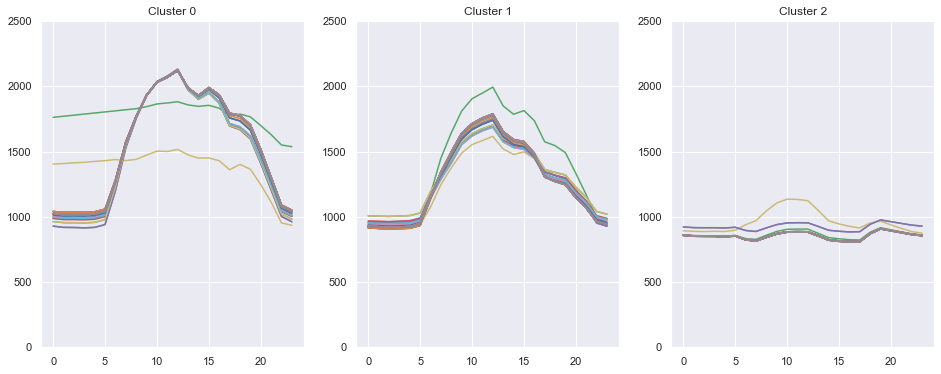

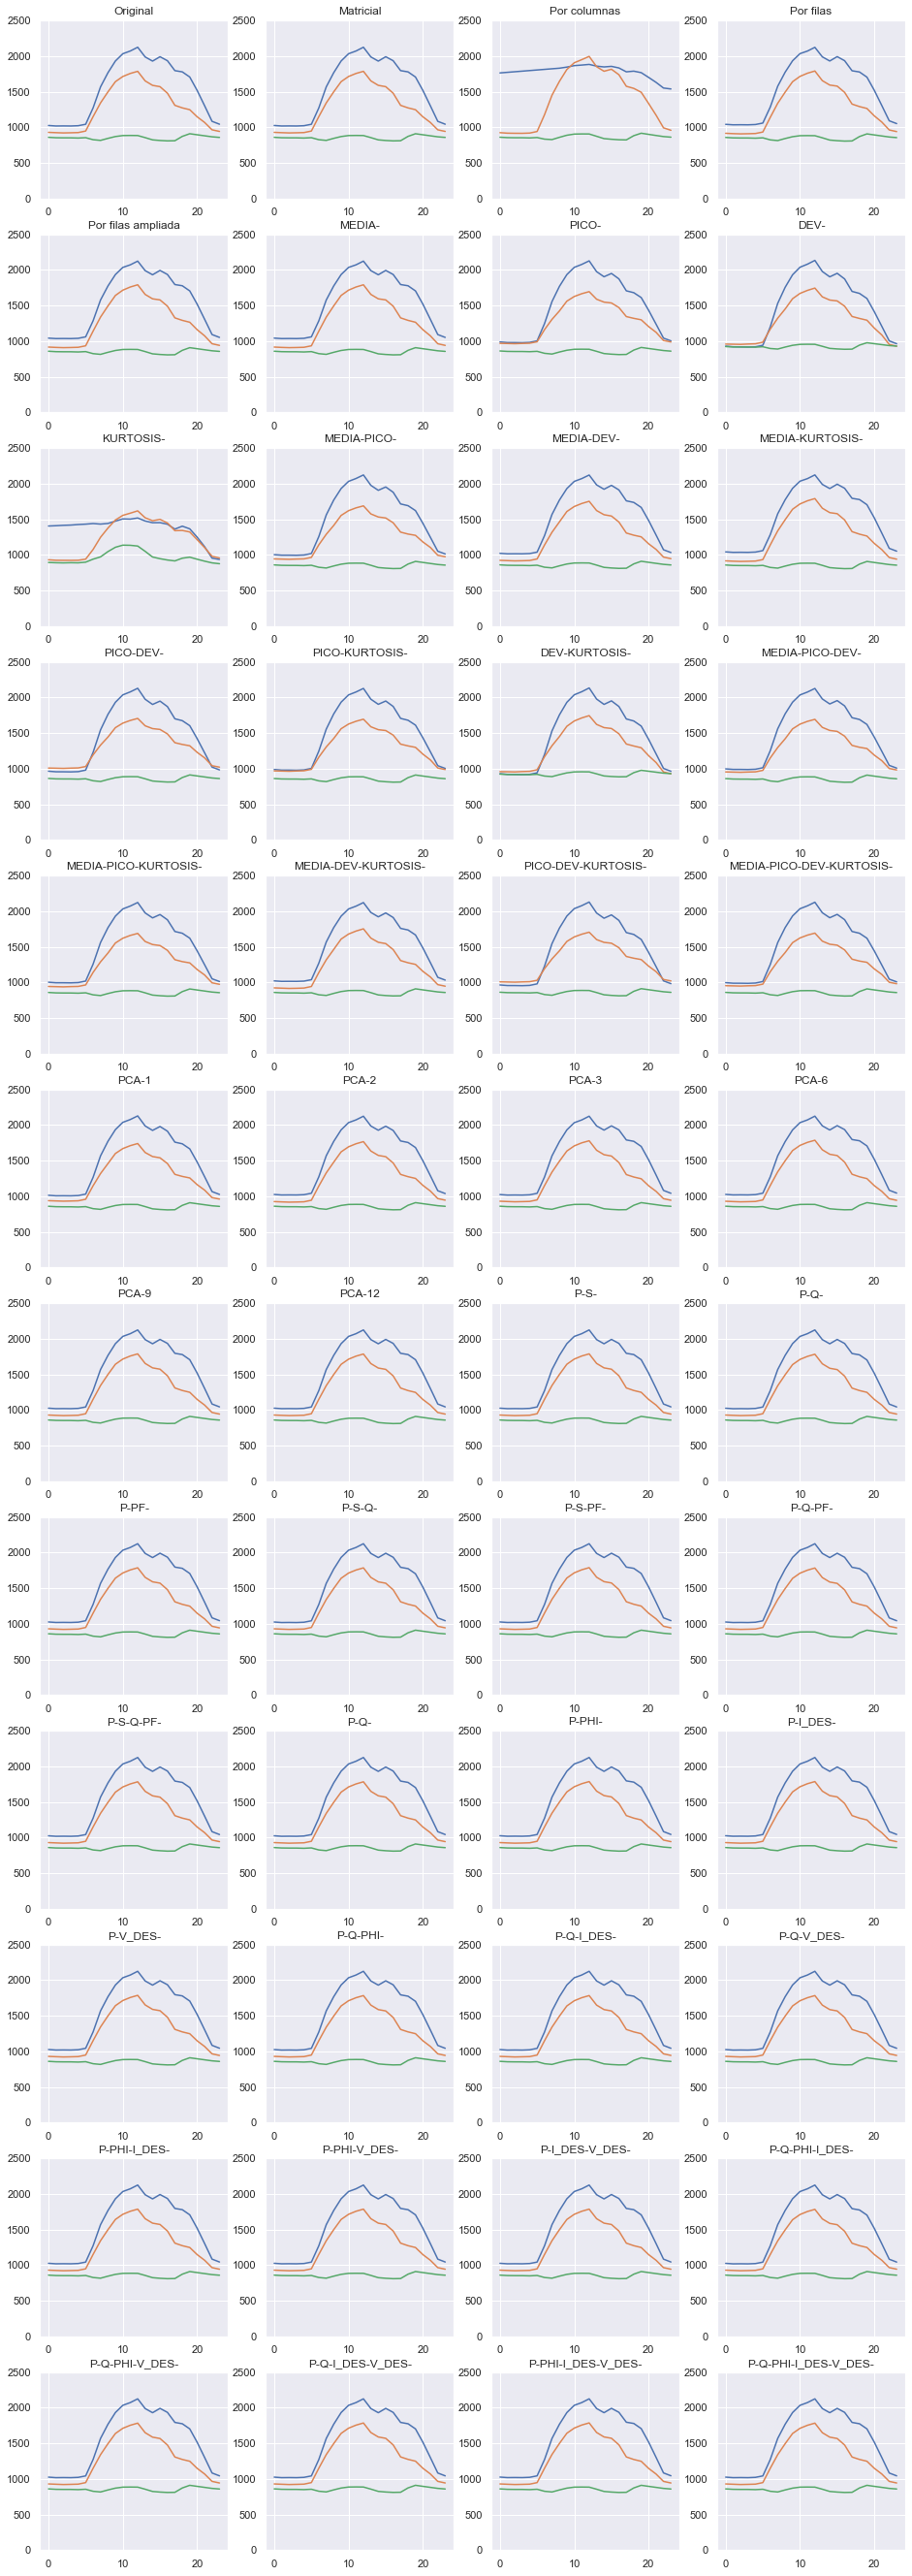

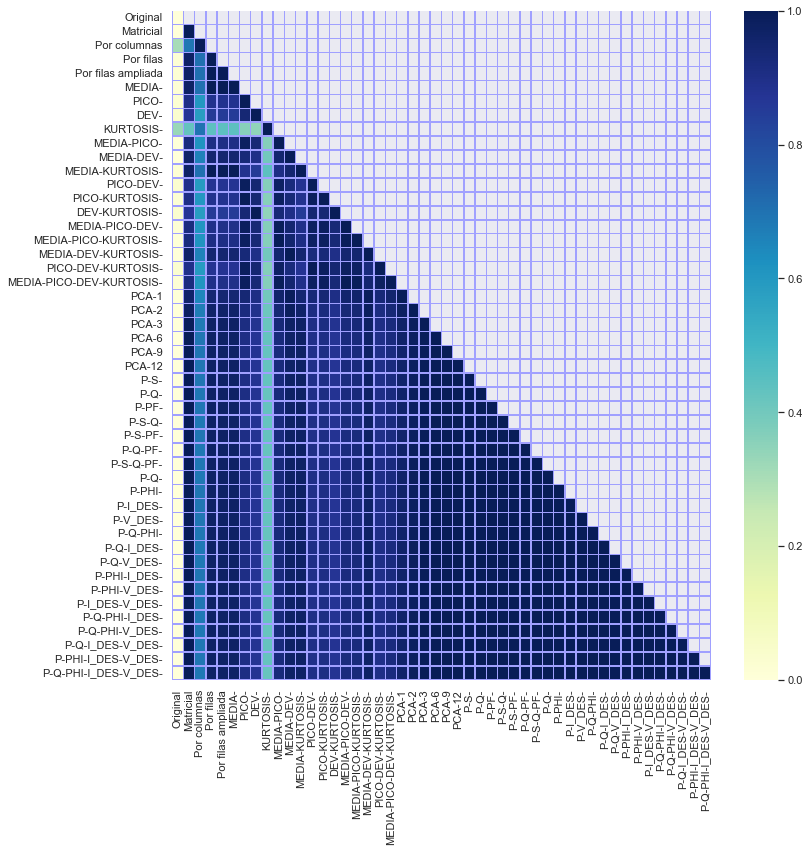

In [10]:
plt.rcParams["figure.figsize"] = (16,6)
plotCompararPerfiles(CLOrdenados,3,dirfigs+"perfilesBaseComparados.eps")
plotPerfilesSeparados(CLOrdenados,Casos,4,dirfigs+"perfilesBaseSeparados.eps")
plotHeatmapCorrs(LabelsOrdenados,Casos,dirfigs+"heatmapBase.eps")


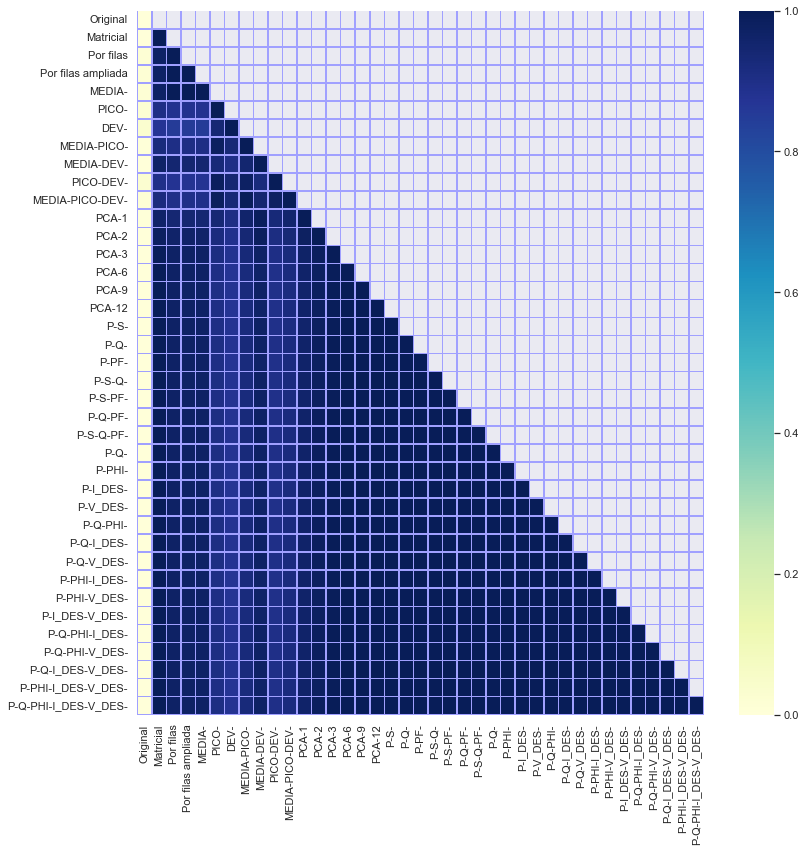

In [11]:
CasosReducido = Casos.copy()
LabelsReducido= LabelsOrdenados.copy()
Eliminar=["Por columnas",
          "KURTOSIS-","MEDIA-KURTOSIS-","PICO-KURTOSIS-","DEV-KURTOSIS-",
          "MEDIA-PICO-KURTOSIS-","MEDIA-DEV-KURTOSIS-","PICO-DEV-KURTOSIS-",
          "MEDIA-PICO-DEV-KURTOSIS-"]
for i in range(0,len(Eliminar)):
    index= CasosReducido.index(Eliminar[i])
    del CasosReducido[index]
    del LabelsReducido[index]
plotHeatmapCorrs(LabelsReducido,CasosReducido,dirfigs+"heatmapReducidos.eps")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


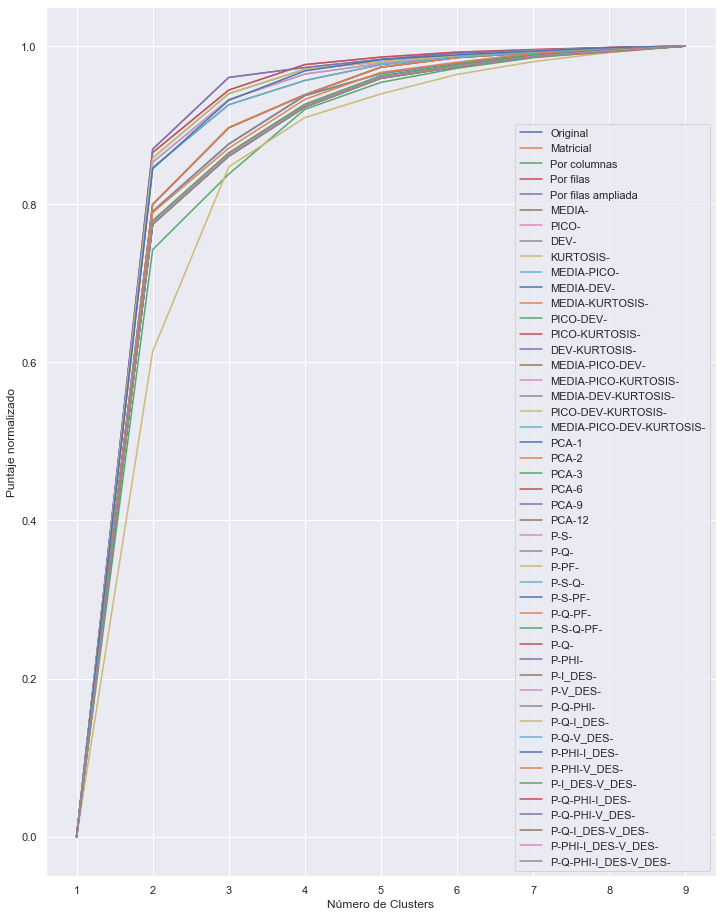

In [12]:
SCX=elbowComparado(Valores,10,Casos,dirfigs+"codosComparados.eps")

# Fechas y días

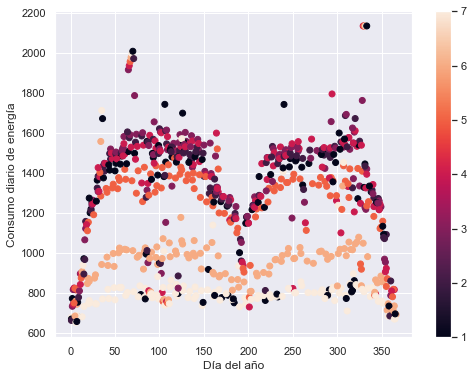

In [13]:
import datetime

#datetime.date(2016, 10, 6).weekday()
DOW=[]
DOY=[]
FF=dd.index.date
for i in range(0,len(FF)):
    DOW.append(FF[i].isoweekday())
    DOY.append(FF[i].timetuple().tm_yday)

sns.set(rc={'figure.figsize':(8,6)})
PMEDIA=Valores[3][:,24]
plt.scatter(DOY,PMEDIA,c=DOW)
plt.colorbar()
plt.xlabel("Día del año")
plt.ylabel("Consumo diario de energía")
plt.savefig(dirfigs+"diaSemanaAno.eps", format='eps')
plt.show()

# Tarifas

In [14]:
def crearTarifas(perfiles,TarifaPlana,factor):
    Tarifas=np.zeros(shape=np.shape(perfiles))
    CT=np.zeros(shape=(len(perfiles),1))
    for i in range(0,len(perfiles)):
        CT[i]=TarifaPlana*np.sum(perfiles[i])
        mn=np.min(perfiles[i])
        mx=np.max(perfiles[i])
        md=np.mean(perfiles[i])
        for j in range(0,len(perfiles[i])):
            altura=0
            if mx>mn:
                altura=(perfiles[i][j]-mn)/(mx-mn)
            if altura<0.2:
                Tarifas[i][j]=0.0
            elif altura<0.8:
                Tarifas[i][j]=0.1
            else:
                Tarifas[i][j]=1.0
        PP=0
        PV=0
        for j in range(0,len(perfiles[i])):
            PP=PP + perfiles[i][j]
            PV=PV + ((Tarifas[i][j]-0)*perfiles[i][j]/(1-0))
        fmin=CT[i]/(PP + ((factor-1)*PV))
        fmax=factor*fmin
        for j in range(0,len(Tarifas[i])):
            Tarifas[i][j]=fmin + (Tarifas[i][j]-0)*(fmax-fmin)/(1-0)
    return Tarifas

def aplicarTarifaFija(dd,Tarifas):
    costo=[]
    for i in range(0,len(dd)):
        suma=0
        for j in range(0,len(dd[i])):
            suma=suma+dd[i][j]*Tarifas[j]
        costo.append(suma)
    return costo

def aplicarTarifas(dd,Tarifas,Labels):
    costo=[]
    for i in range(0,len(dd)):
        suma=0
        for j in range(0,len(dd[i])):
            suma=suma+dd[i][j]*Tarifas[Labels[i],j]
        costo.append(suma)
    return costo

def aplicarTarifaPlana(dd,Tarifa):
    costo=[]
    for i in range(0,len(dd)):
        suma=0
        for j in range(0,len(dd[i])):
            suma=suma+dd[i][j]*Tarifa
        costo.append(suma)
    return costo

def calcularDeltaIngresos(dd,TarifaPlana,factorTarifario,Centros,Labels):
    costoPlana  = aplicarTarifaPlana(dd.values,TarifaPlana);
    Tarifa      = crearTarifas(Centros,TarifaPlana,factorTarifario)
    costoTarifa = aplicarTarifas(dd.values,Tarifa,Labels)
    IPlana =np.sum(costoPlana)
    ITarifa=np.sum(costoTarifa)
    Delta=(ITarifa-IPlana)/IPlana*100
    return Delta, ITarifa, np.min(Tarifa),np.max(Tarifa),np.std(costoTarifa)/np.mean(costoTarifa)


In [15]:
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters)
Casos=[]
Valores=[]
kmeans.fit(dd.values)
CL=[]
Labels=[]

experimentoOriginal(dd,kmeans)
experimentoEstandarizacion(dd,kmeans)
experimentoGeometria(dd,kmeans)
n_components=[1,2,3]
experimentoPCA(dd,kmeans,n_components)
columnasAmpliadoA=['kW_Tot','KVA_Tot','kVAr_Tot','PF_TOT','Z_ANG_MEDIO','IL_DESBALANCE','VL_DESBALANCE']
aliasAmpliadoA=['P','S','Q','PF','PHI','I_DES','V_DES']
experimentoAmpliadoSimple(dd,kmeans,columnasAmpliadoA,aliasAmpliadoA)
[CLOrdenados,LabelsOrdenados]=relabelCompleto(Labels,CL)


[1, 0]


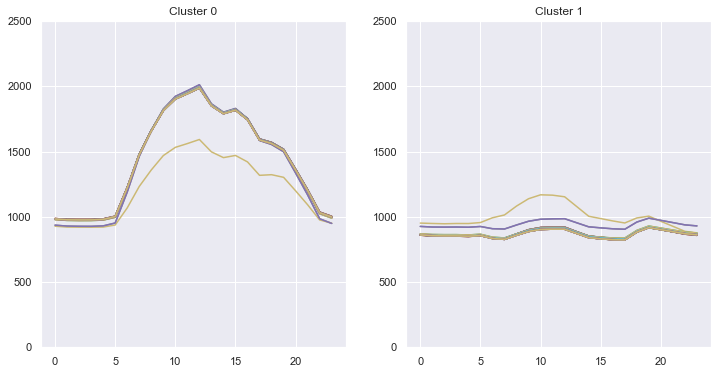

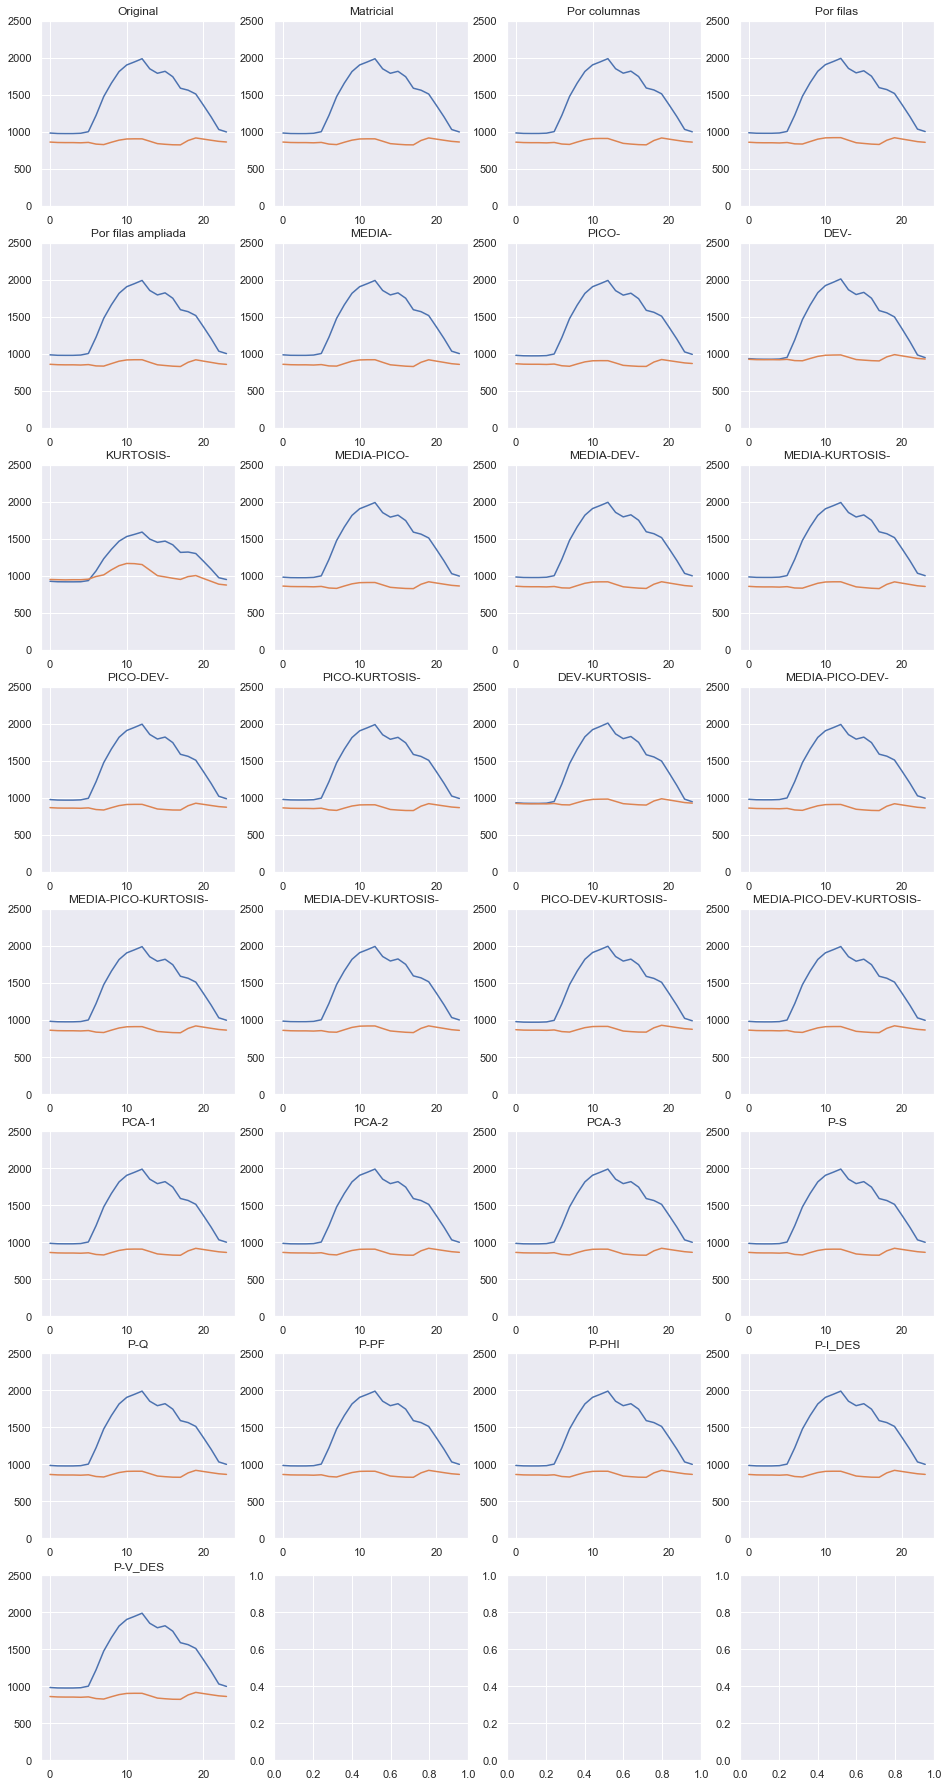

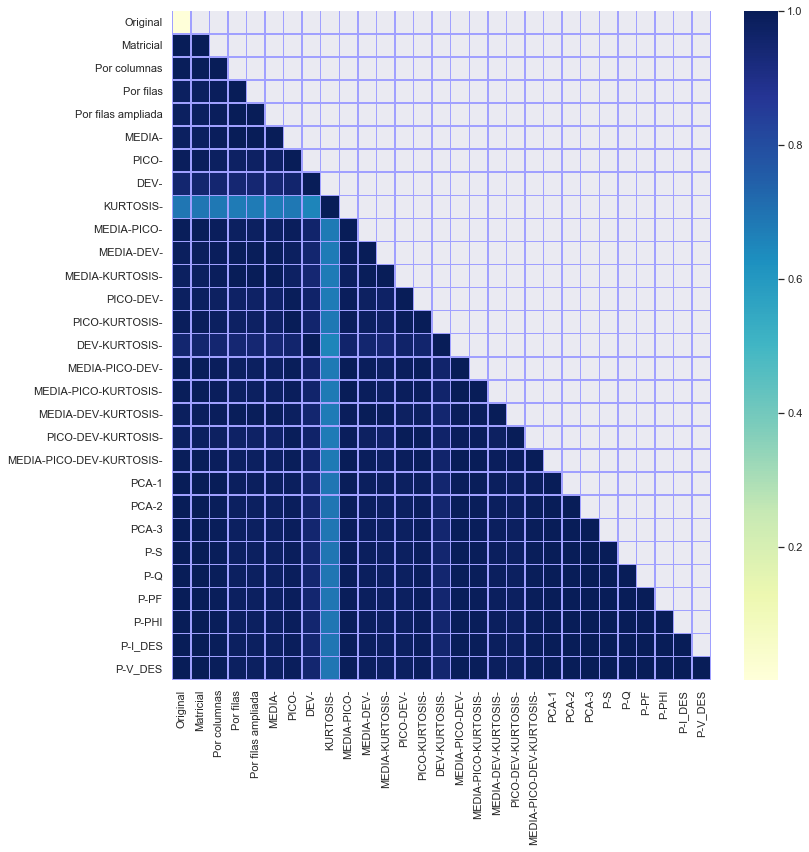

In [16]:
plt.rcParams["figure.figsize"] = (12,6)
plotCompararPerfiles(CLOrdenados,2,dirfigs+"perfilesTarifaComparados.eps")
plotPerfilesSeparados(CLOrdenados,Casos,4,dirfigs+"perfilesTarifaSeparados.eps")
plotHeatmapCorrs(LabelsOrdenados,Casos,dirfigs+"heatmapTarifa.eps")


# evaluar tarifas

In [17]:
# SOLO PARA DOS TARIFAS
def evaluarTarifas(dd,TarifaPlana,Tarifas,Labels):
    costoPlana  = aplicarTarifaPlana(dd.values,TarifaPlana)
#    LabelsClases=[]
#    for i in range(0,len(Labels)):
#        if Labels[i] == 0:
#            LabelsClases.append(1)
#        else:
#            LabelsClases.append(0)
#    costoTarifa = aplicarTarifas(dd.values,Tarifas,LabelsClases)
    costoTarifa = aplicarTarifas(dd.values,Tarifas,Labels)
    
    costoSegunUsuario=[]
    clasificaIgual=0
#    for i in range(0,len(Tarifas)):
    C0=aplicarTarifaFija(dd.values,Tarifas[0])
    C1=aplicarTarifaFija(dd.values,Tarifas[1])
    for i in range(0,len(dd)):
        costoMinimo=min(C0[i],C1[i])
        costoSegunUsuario.append(costoMinimo)
        if costoTarifa[i] == costoMinimo:
            clasificaIgual=clasificaIgual+1
    
    costoTarifaPlana=sum(costoPlana)
    costoTarifaPropia=sum(costoTarifa)
    costoMinimoUsuario=sum(costoSegunUsuario)

    return costoMinimoUsuario,costoTarifaPlana,costoTarifaPropia,clasificaIgual

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


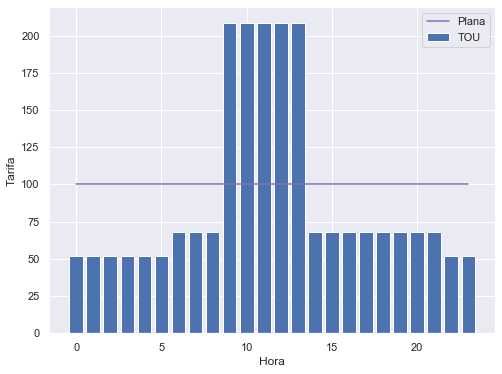

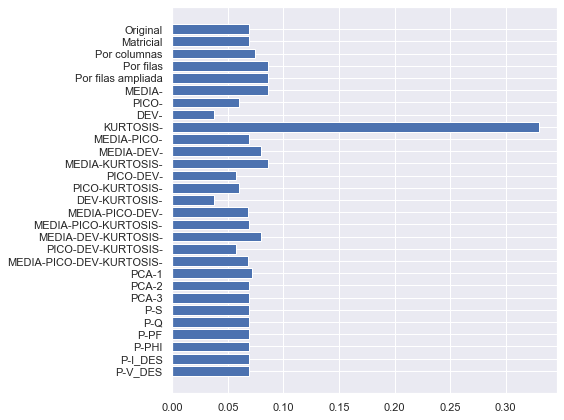

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


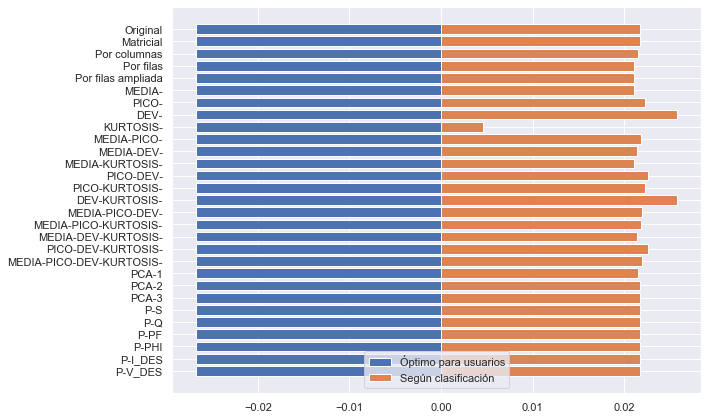

In [18]:
perfilMedio=np.mean(Valores[0],0)
perfilPlano=np.ones(shape=np.shape(perfilMedio))
Perfiles=[]
Perfiles.append(perfilMedio)
Perfiles.append(perfilPlano)
Tarifas=crearTarifas([perfilMedio, perfilPlano],100,4)

plt.rcParams["figure.figsize"] = (8,6)
plt.bar(list(range(0, 24)),Tarifas[0],label='TOU')
plt.plot(Tarifas[1],'m-',label='Plana')
plt.xlabel("Hora")
plt.ylabel("Tarifa")
plt.legend()
plt.savefig(dirfigs+"tarifas.eps", format='eps')
plt.show()

costosUsuarios=[]
costosTarifaPlana=[]
costosTarifaPropia=[]
coincidenciasA=[]
coincidencias=[]
comparaUsuarioPlana=[]
comparaPropiaPlana=[]
comparaPropiaUsuario=[]

for i in range(0,len(Labels)):
    costoUsuario,costoTarifaPlana,costoTarifaPropia,coincide=evaluarTarifas(dd,100,Tarifas,LabelsOrdenados[i])
    costosUsuarios.append    (costoUsuario)
    costosTarifaPlana.append (costoTarifaPlana)
    costosTarifaPropia.append(costoTarifaPropia)
    coincidencias.append((coincide/len(dd)))
    comparaUsuarioPlana.append ((costoUsuario     -costoTarifaPlana)/costoTarifaPlana)
    comparaPropiaPlana.append  ((costoTarifaPropia-costoTarifaPlana)/costoTarifaPlana)
    comparaPropiaUsuario.append((costoTarifaPropia-costoUsuario)/(costoUsuario))

plt.rcParams["figure.figsize"] = (8,6)

fig, ax = plt.subplots()
ax.barh(Casos,coincidencias)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(dirfigs+"coincidencias.eps", format='eps')
plt.show()

plt.rcParams["figure.figsize"] = (10,6)
fig, ax = plt.subplots()
ax.barh(Casos,comparaUsuarioPlana,label="Óptimo para usuarios")
ax.barh(Casos,comparaPropiaPlana,label="Según clasificación")
ax.invert_yaxis()
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig(dirfigs+"comparaContraPlana.eps", format='eps')
plt.show()


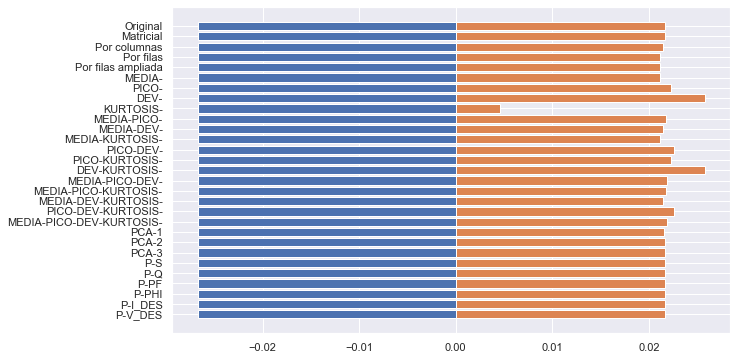

In [19]:
fig, ax = plt.subplots()
ax.barh(Casos,comparaUsuarioPlana)
ax.barh(Casos,comparaPropiaPlana)
ax.invert_yaxis()
#ax.set_xlim(0.95,1.00)
plt.show()



In [20]:
print(np.transpose(comparaUsuarioPlana))
print(np.transpose(comparaPropiaPlana))

[-0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815
 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815
 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815
 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815
 -0.02673815 -0.02673815 -0.02673815 -0.02673815 -0.02673815]
[0.02170438 0.02170438 0.02146604 0.02112412 0.02112412 0.02112412
 0.02226111 0.02580129 0.00458193 0.02181458 0.021425   0.02112412
 0.02260907 0.02226111 0.02580129 0.0219335  0.02181458 0.021425
 0.02260907 0.0219335  0.02154775 0.02170438 0.02170438 0.02170438
 0.02170438 0.02170438 0.02170438 0.02170438 0.02170438]
